In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import powerlaw
from operator import itemgetter
%matplotlib inline

In [2]:
def compute_spike_count(X):
    """
    Args:
        X: (np.array): spike train

    Returns:

    """
    return np.sum(X, axis=1)


def compute_avalanche(X: np.array, threshold=None):
    """Avalanche sizes, durations and interval sizes

        - Set the neural activity =0 if < activity_threshold
        - Slice the array by non-zero value indices
        - Count the number of items in each slices: Duration of avalanches
        - Sum the items in each slices: Size of avalanches
        - Slice the array into zero value indices
        - Count number of items in each slices: Duration of inter avalanche intervals

    Args:
        X (np.array): spike train

        threshold (int, optional): Threshold of number of spikes at each time step. Spike counts below threshold will be set to zero.Defaults to 1.
    Returns:
        spike_count (np.array): Number of spikes at each time step

        avalanche_durations (np.array): Avalanches durations

        avalanche_sizes (np.array): Number of spikes within each avalanche duration

        iai (np.array): Time interval between avalanches
    """

    spike_count = np.asarray(compute_spike_count(X))
    if threshold is None:
        threshold = np.median(spike_count) / 2
    # print(f"threshold, {threshold}")
    spike_count[spike_count < threshold] = 0

    # Avalanche size and duration
    # Get the non zero indices
    aval_idx = np.nonzero(spike_count)[0]

    # Group indices by a consecutiveness
    aval_indices = []
    for k, g in itertools.groupby(enumerate(aval_idx), lambda ix: ix[0] - ix[1]):
        aval_indices.append(list(map(itemgetter(1), g)))

    # Using group indices, pick the correpondning items in the spike_count list
    avalanches = []
    for val in aval_indices:
        avalanches.append(list(spike_count[val]))

    # Avalanche sizes
    avalanche_sizes = [sum(avalanche) for avalanche in avalanches]
    # Avalanche duration
    avalanche_durations = [len(avalanche) for avalanche in avalanches]

    # Inter avalanche intervals

    # Get the indices where spike count =0
    silent_idx = np.where(spike_count == 0)[0]

    silent_indices = []
    # Group indices by consecutiveness
    for k, g in itertools.groupby(enumerate(silent_idx), lambda ix: ix[0] - ix[1]):
        silent_indices.append(list(map(itemgetter(1), g)))
    iai_ = []
    for val in silent_indices:
        iai_.append(list(spike_count[val]))
    # Duration of inter-avalanche intervals
    iai = [len(intervals) for intervals in iai_]

    return spike_count, np.array(avalanche_sizes), np.array(avalanche_durations), np.array(iai)

torch.Size([5000, 22]) torch.Size([4, 5000, 5000])
log.max 1


Text(0.5, 0, 'time(ms)')

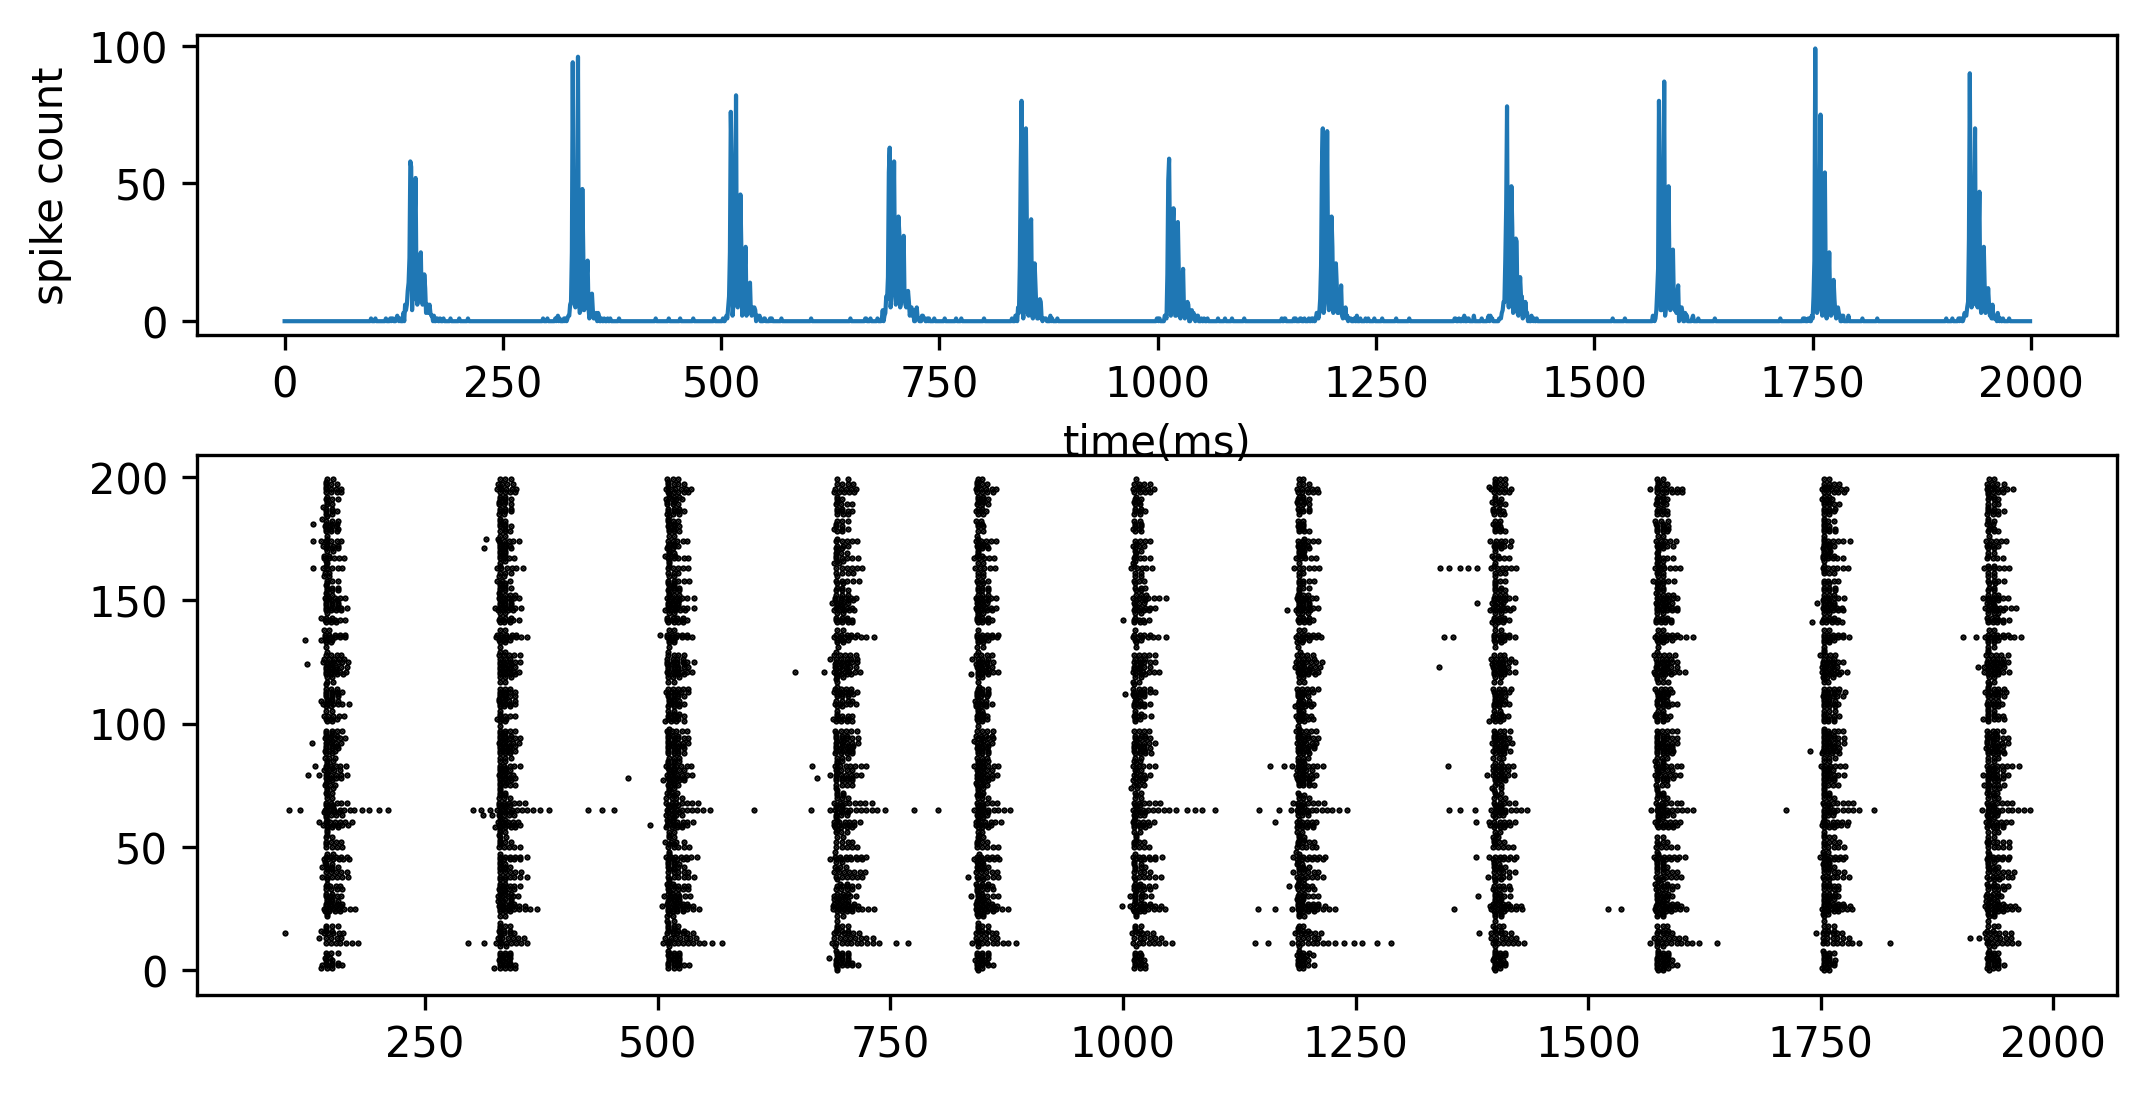

In [2]:
import torch
from brain_block.random_initialize import connect_for_block
from brain_block.block import block
# from analysis.spike_statistics import instantaneous_rate
# from scipy.ndimage import gaussian_filter1d

# critical_gui = torch.tensor([0.02560000000, 0.00043232323232323246, 0.16830848484848485, 0.018471969696969695])
# subcrtical_gui = (0.0115, 0.0020, 0.2517, 0.0111)
# supercritical_gui = [0.0258467  0.00048485 0.13888889 0.02006173]
property, w_uij = connect_for_block("../data/degree_distribution_d500/sigma_0/single")
# ampa_contribution = np.linspace(0.5, 1, num=100, endpoint=True)
# gabaA_contribution = np.linspace(0., 0.5, num=100, endpoint=True)
# contribution = np.stack(np.meshgrid(ampa_contribution, gabaA_contribution, indexing='ij'), axis=-1).reshape((-1, 2))
# ampa_contribution = contribution[:, 0]
# gabaA_contribution = contribution[:, 1]
# ampa = ampa_contribution / 34
# nmda = (1 - ampa_contribution) / 250
# gabaA = gabaA_contribution / 2
# gabaB = (1 - gabaA_contribution) / 36
# para =np.stack([ampa, nmda, gabaA, gabaB], axis=1) # (1000, 4)
# specific_gui = para[75*100+55]
# print(specific_gui)
# property[:, (10, 11, 12, 13)] = torch.from_numpy(specific_gui.astype(np.float32))
# assign specific gui
property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=0.1,
)
log_all = []
synaptic_current = []
for time in range(30000):
    print(time, end='\r')
    B.run(noise_rate=0.0003, isolated=False)
    if time >= 10000:
        synaptic_current.append(B.I_ui[:, 1500].cpu().numpy())
        log_all.append(B.active.data.cpu().numpy())
synaptic_current = np.array(synaptic_current)
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, :1000]
log = log.reshape((-1, 10, 1000))
log = log.sum(axis=1)
# np.save("critical_spike2.npy", log)
print("log.max", log.max())
# fr = instantaneous_rate(sub_log, bin_width=5)
# rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
torch.cuda.empty_cache()

fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*log[-2000:, :200].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(log[-2000:, :200], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

torch.Size([5000, 22]) torch.Size([4, 5000, 5000])
log.max 1


Text(0, 0.5, 'spike count')

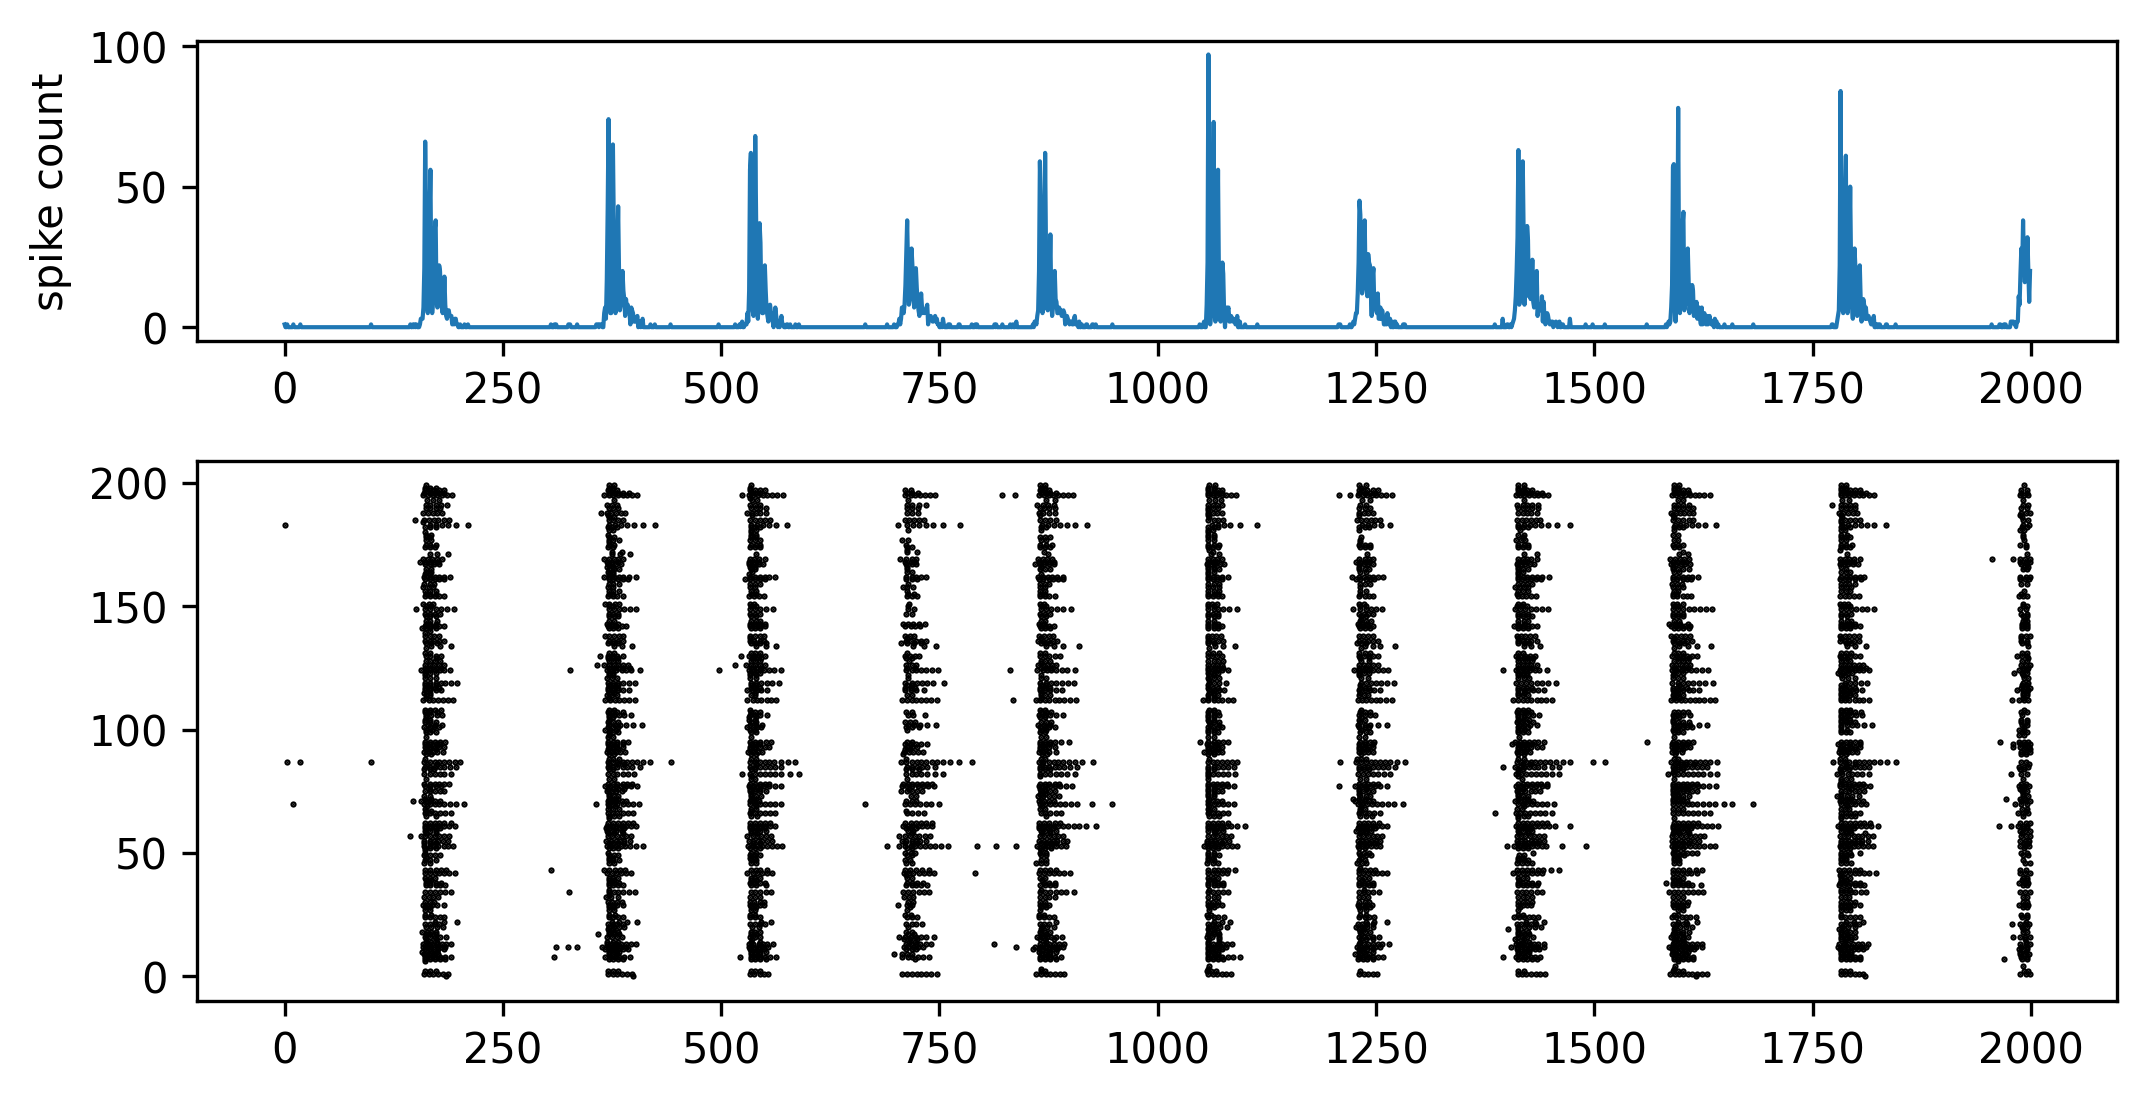

In [3]:
property, w_uij = connect_for_block("../data/degree_distribution_d500/sigma_200/single")
property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=0.1,
)
log_all = []
for time in range(30000):
    print(time, end='\r')
    B.run(noise_rate=0.0003, isolated=False)
    if time >= 10000:
        log_all.append(B.active.data.cpu().numpy())
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, :1000]
log = log.reshape((-1, 10, 1000))
log = log.sum(axis=1)
# np.save("critical_spike2.npy", log)
print("log.max", log.max())
torch.cuda.empty_cache()

fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*log[-2000:, :200].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(log[-2000:, :200], axis=1), lw=1)
ax.set_ylabel("spike count")


# Critical Spike

Text(0.5, 0, 'time(ms)')

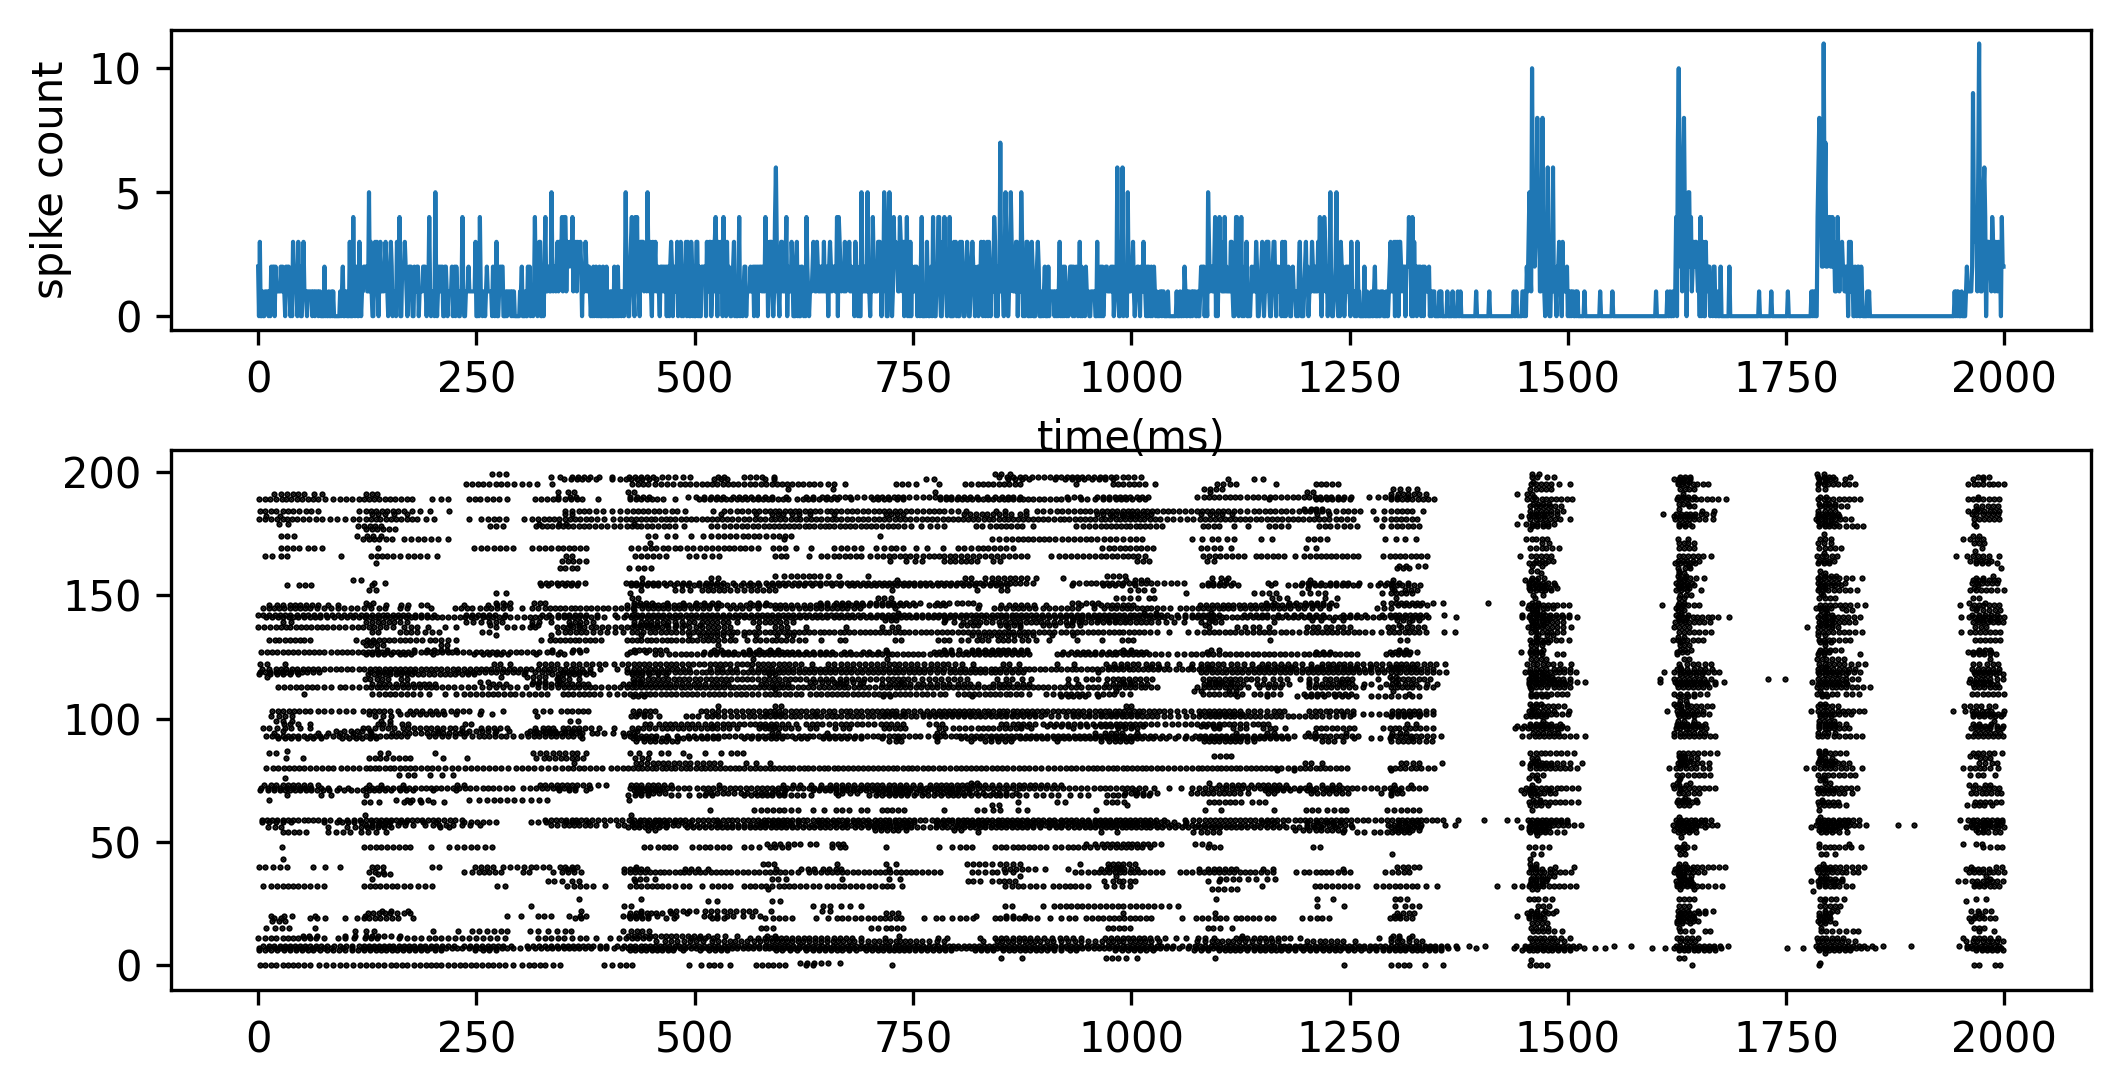

In [3]:
critical_spike = np.load("critical_spike2.npy")
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*critical_spike[-2000:, :200].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(critical_spike[-2000:, 200:250], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

distance 0.9937223556748388
fit.alpha 1.875, fit.ks_distance 0.02
aval_size.shape (438612,)


Text(0, 0.5, 'probablity')

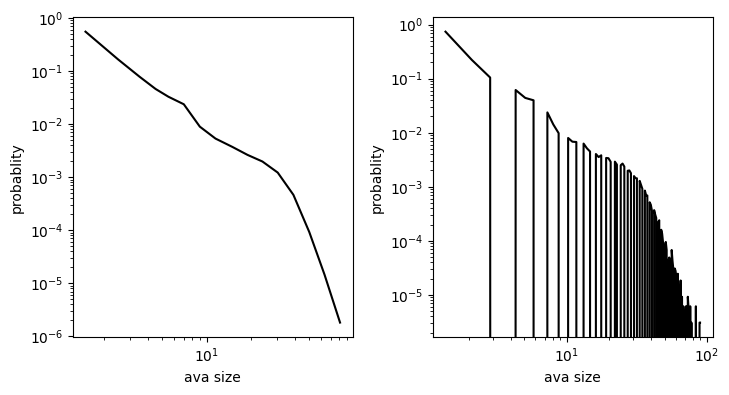

In [20]:
aval_size_total = []
aval_dur_total = []
for i in range(80):
    seed = np.random.randint(low=0, high=1000, size=(100), dtype=np.int32)
    _, aval_size, aval_dur, _ = compute_avalanche(critical_spike[:, seed], 1)
    aval_size_total.append(aval_size)
    aval_dur_total.append(aval_dur)
aval_size_total = np.concatenate(aval_size_total, axis=0)
aval_dur_total = np.concatenate(aval_dur_total, axis=0)
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_axes([0.1, 0.1, 0.35, 0.8])
fit = powerlaw.Fit(aval_dur_total, xmin=aval_dur_total.min(), xmax=aval_dur_total.max(), discrete=True)
distance = fit.power_law.Kappa
print("distance", distance)
print(f"fit.alpha {fit.alpha:.3f}, fit.ks_distance {fit.D:.2f}")
fit.plot_pdf(ax=ax, original_data=False, color="k", lw=1.5)
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

print("aval_size.shape", aval_dur_total.shape)
hist, edges = np.histogram(aval_dur_total, bins=120, density=True)
# nonzero_hist = hist[hist.nonzero()[0]]
# nonzero_min = np.min(nonzero_hist)
# print(nonzero_min)
# hist = np.where(hist == 0, nonzero_min, hist)
ax = fig.add_axes([0.55, 0.1, 0.35, 0.8])
ax.plot((edges[1:] + edges[:-1]) / 2, hist, color="k", lw=1.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")


# SubCritcial spike

fit.alpha 1.175, fit.ks_distance 0.19
aval_size.shape (186766,)


Text(0, 0.5, 'probablity')

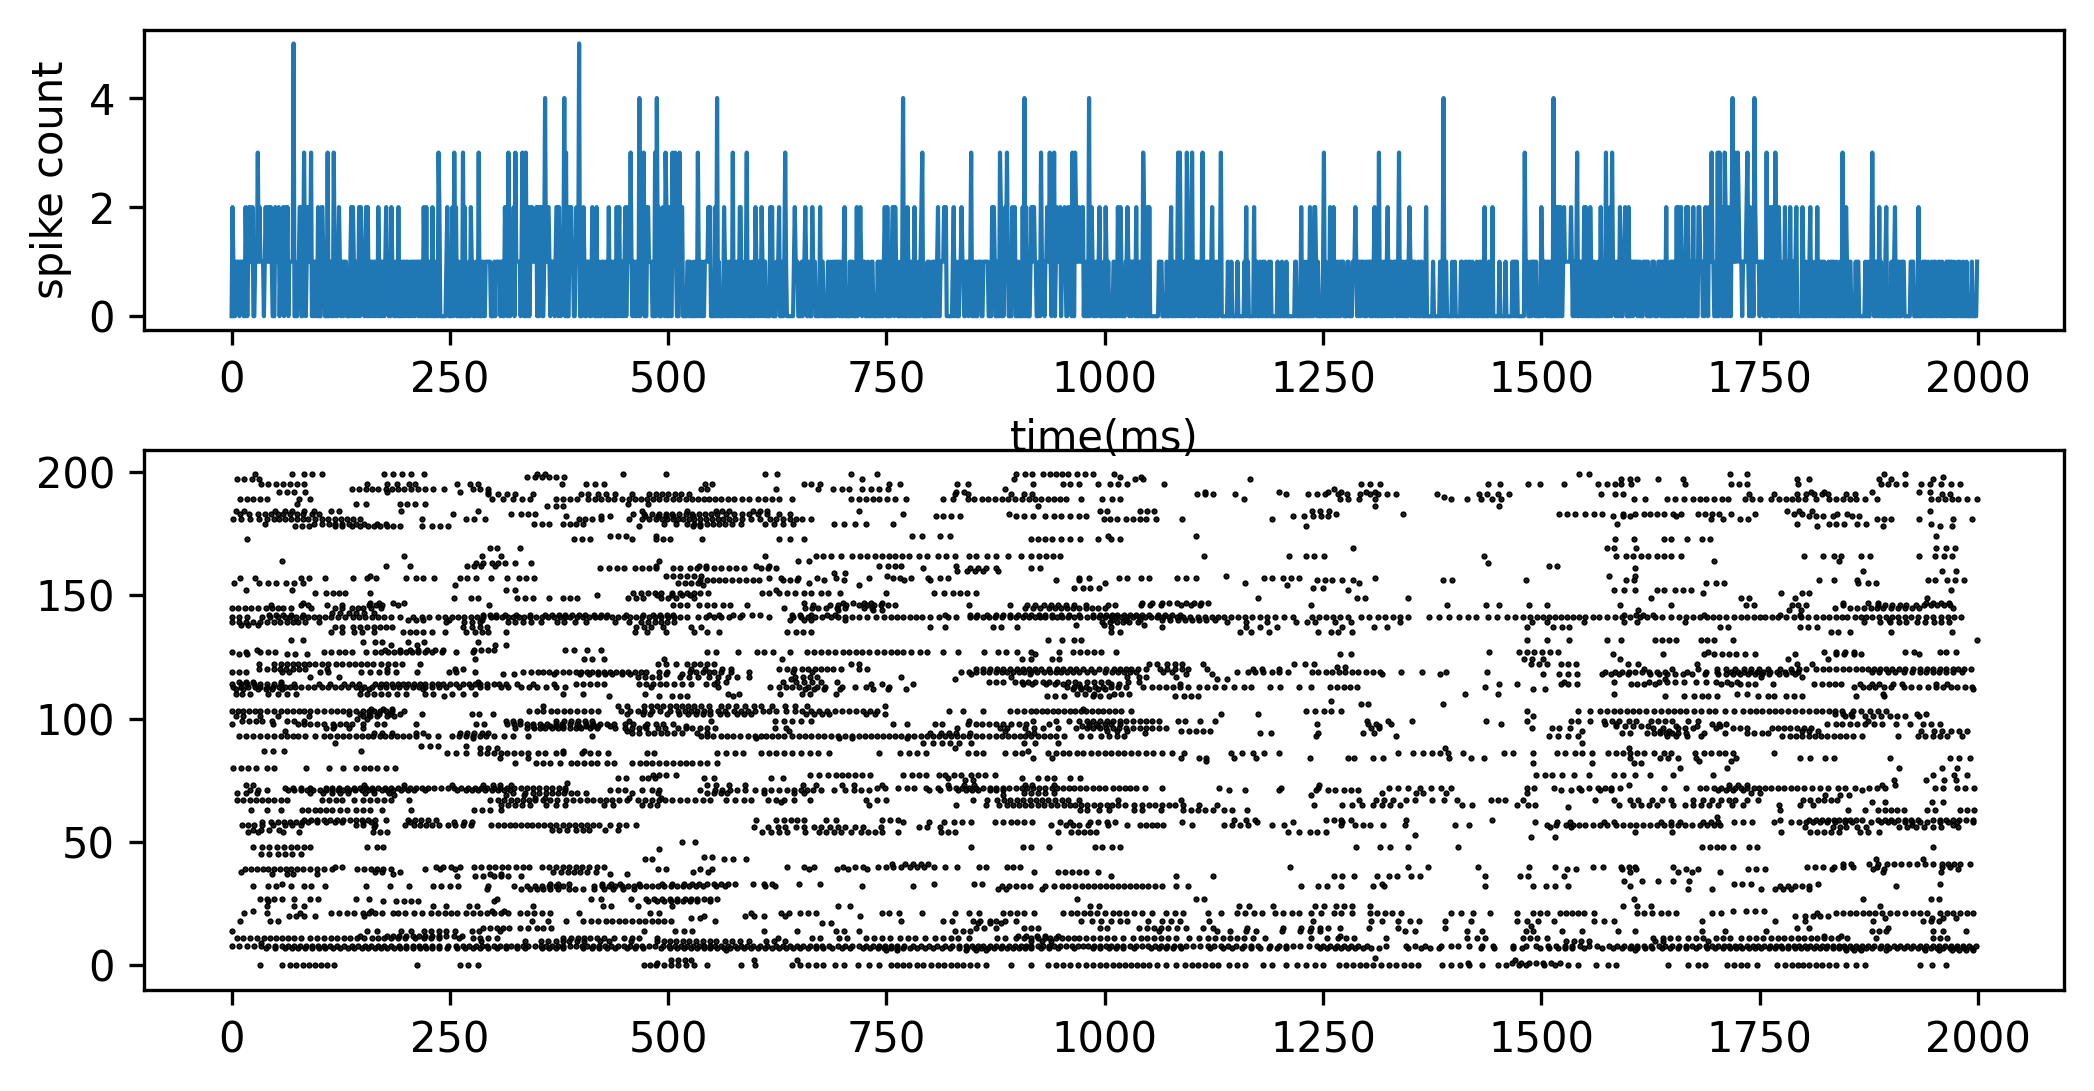

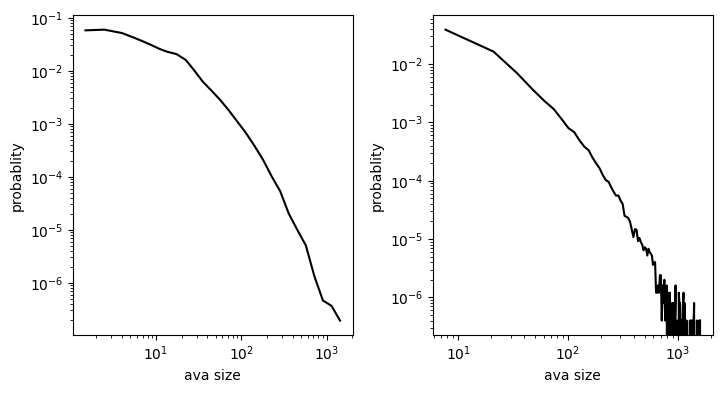

In [12]:
subcritical_spike = np.load("subcritical_spike.npy")
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*subcritical_spike[-2000:, :200].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(subcritical_spike[-2000:, 200:250], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

aval_size_total = []
aval_dur_total = []
for i in range(40):
    seed = np.random.randint(low=0, high=1000, size=(200), dtype=np.int32)
    _, aval_size, aval_dur, _ = compute_avalanche(subcritical_spike[:, seed], 1)
    aval_size_total.append(aval_size)
    aval_dur_total.append(aval_dur)
aval_size_total = np.concatenate(aval_size_total, axis=0)
aval_dur_total = np.concatenate(aval_dur_total, axis=0)

fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_axes([0.1, 0.1, 0.35, 0.8])
fit = powerlaw.Fit(aval_size_total, xmin=aval_size_total.min(), xmax=aval_size_total.max(), discrete=True)
print(f"fit.alpha {fit.alpha:.3f}, fit.ks_distance {fit.D:.2f}")
fit.plot_pdf(ax=ax, original_data=False, color="k", lw=1.5)
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

print("aval_size.shape", aval_size_total.shape)
hist, edges = np.histogram(aval_size_total, bins=120, density=True)
# nonzero_hist = hist[hist.nonzero()[0]]
# nonzero_min = np.min(nonzero_hist)
# print(nonzero_min)
# hist = np.where(hist == 0, nonzero_min, hist)
ax = fig.add_axes([0.55, 0.1, 0.35, 0.8])
ax.plot((edges[1:] + edges[:-1]) / 2, hist, color="k", lw=1.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

# SuperCritical spike

distance 1.0397524109856437
fit.alpha 1.611, fit.ks_distance 0.10
aval_size.shape (119709,)


Text(0, 0.5, 'probablity')

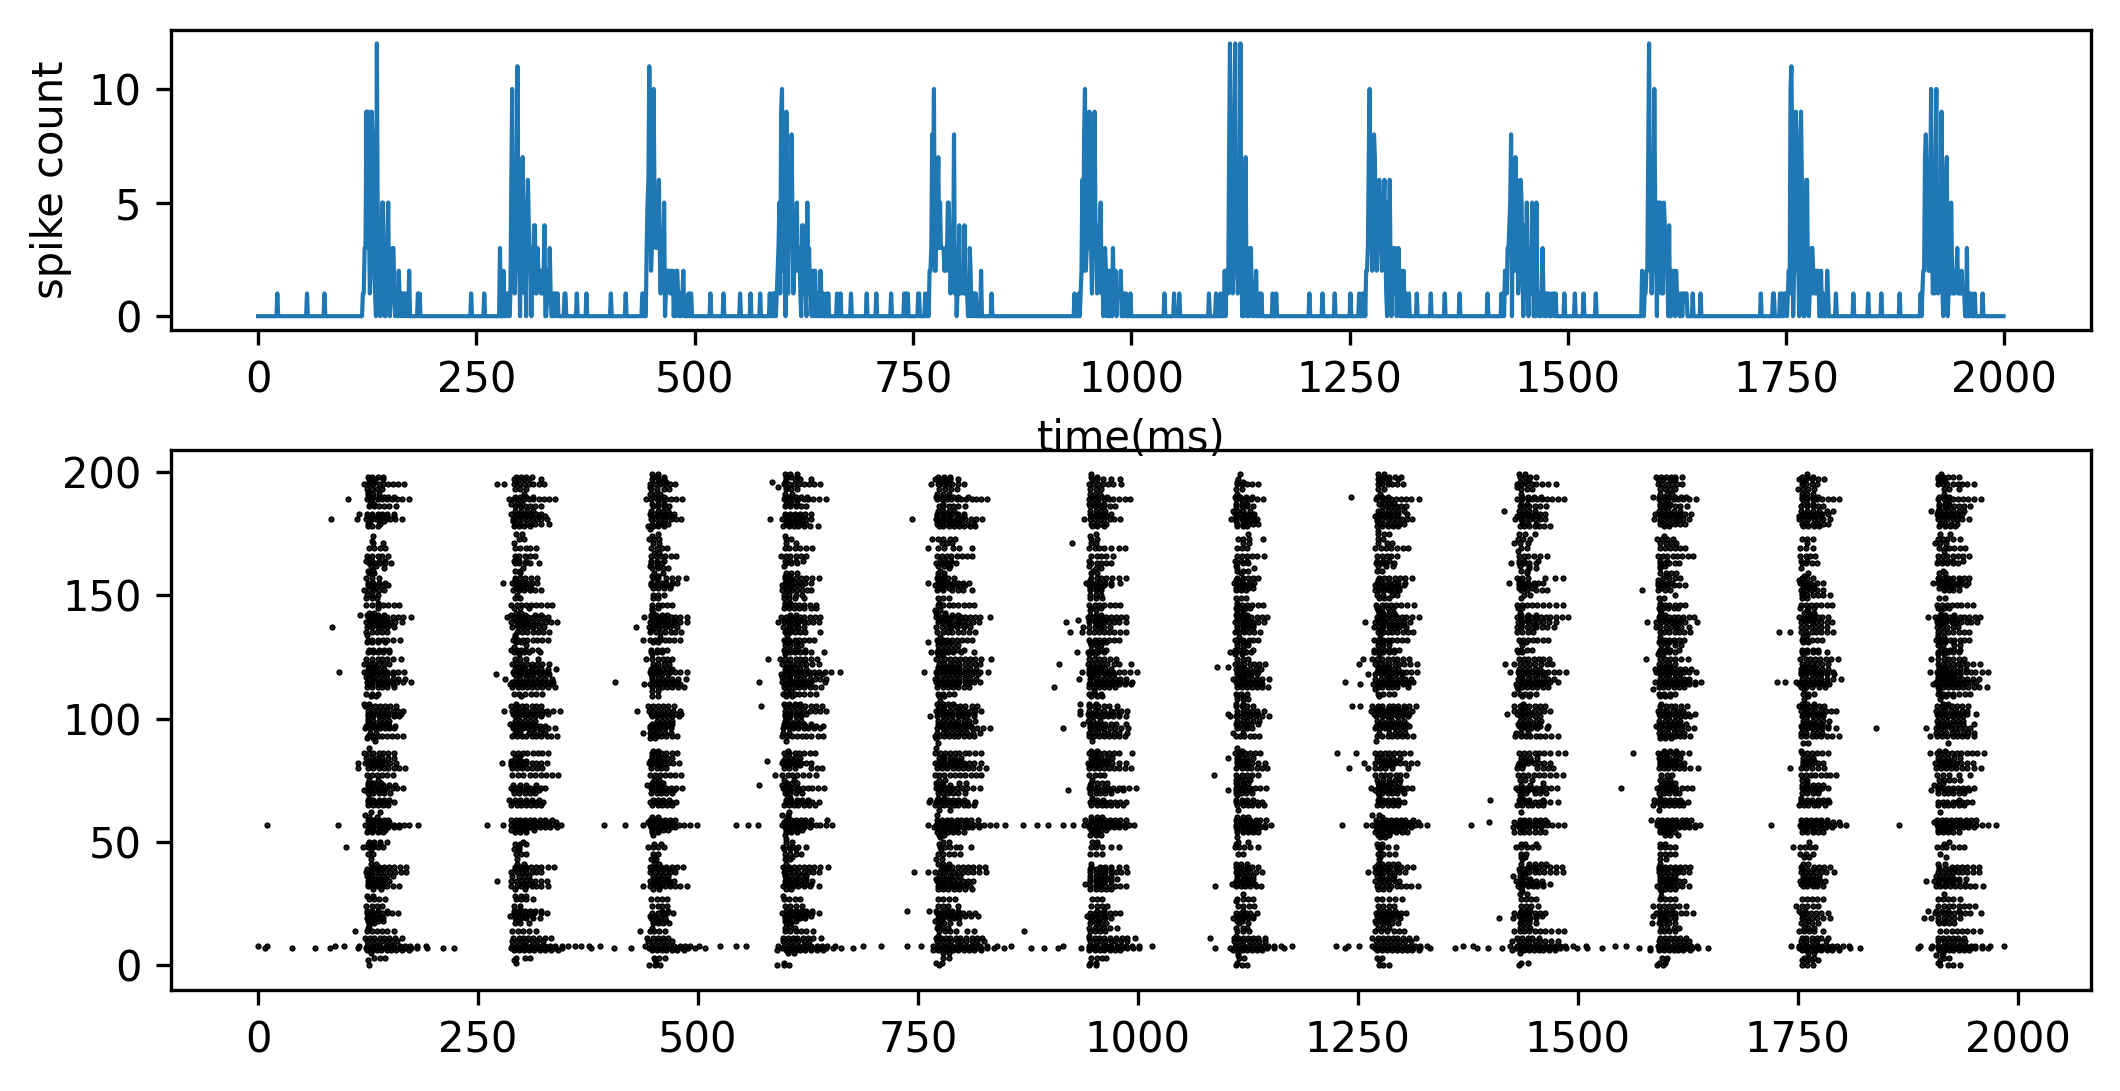

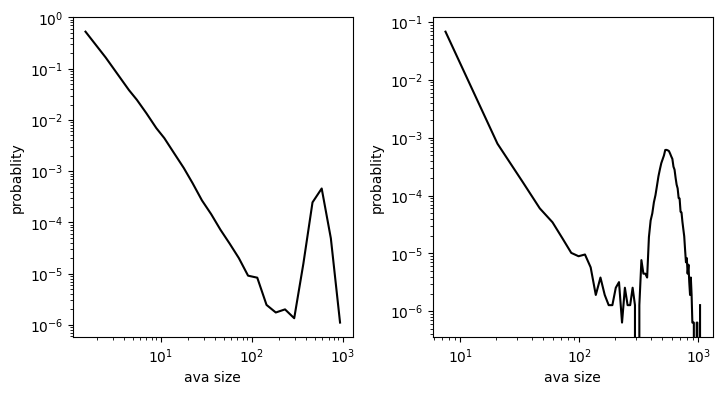

In [13]:
supercritical_spike = np.load("supercritical_spike.npy")
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*supercritical_spike[-2000:, :200].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(supercritical_spike[-2000:, 200:250], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

aval_size_total = []
aval_dur_total = []
for i in range(40):
    seed = np.random.randint(low=0, high=1000, size=(200), dtype=np.int32)
    _, aval_size, aval_dur, _ = compute_avalanche(supercritical_spike[:, seed], 1)
    aval_size_total.append(aval_size)
    aval_dur_total.append(aval_dur)
aval_size_total = np.concatenate(aval_size_total, axis=0)
aval_dur_total = np.concatenate(aval_dur_total, axis=0)

fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_axes([0.1, 0.1, 0.35, 0.8])
fit = powerlaw.Fit(aval_size_total, xmin=aval_size_total.min(), xmax=aval_size_total.max(), discrete=True)
distance = fit.power_law.Kappa
print("distance", distance)
print(f"fit.alpha {fit.alpha:.3f}, fit.ks_distance {fit.D:.2f}")
fit.plot_pdf(ax=ax, original_data=False, color="k", lw=1.5)
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

print("aval_size.shape", aval_size_total.shape)
hist, edges = np.histogram(aval_size_total, bins=80, density=True)
# nonzero_hist = hist[hist.nonzero()[0]]
# nonzero_min = np.min(nonzero_hist)
# print(nonzero_min)
# hist = np.where(hist == 0, nonzero_min, hist)
ax = fig.add_axes([0.55, 0.1, 0.35, 0.8])
ax.plot((edges[1:] + edges[:-1]) / 2, hist, color="k", lw=1.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")


# abstrcat

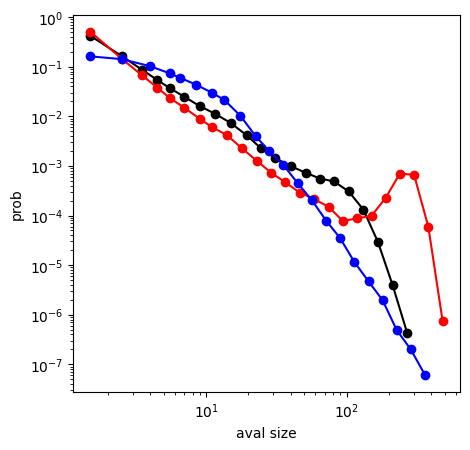

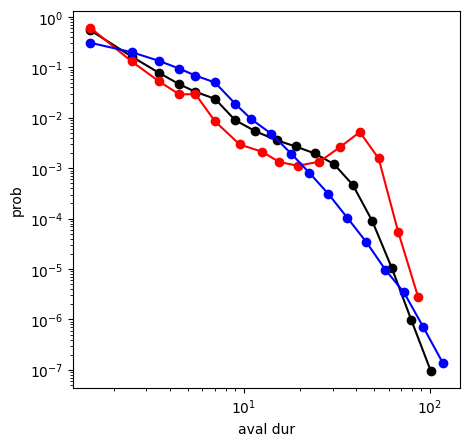

In [19]:
super_spike = np.load("supercritical_spike.npy")
sub_spike = np.load("subcritical_spike.npy")
critical_spike = np.load("critical_spike.npy")

def total_avalanches(spike, threshold=1):
    aval_size_total = []
    aval_dur_total = []
    for i in range(80):
        seed = np.random.randint(low=0, high=1000, size=(100), dtype=np.int32)
        _, aval_size, aval_dur, _ = compute_avalanche(spike[:, seed], threshold)
        aval_size_total.append(aval_size)
        aval_dur_total.append(aval_dur)
    aval_size_total = np.concatenate(aval_size_total, axis=0)
    aval_dur_total = np.concatenate(aval_dur_total, axis=0)
    return aval_size_total, aval_dur_total

fig1 = plt.figure(figsize=(5, 5), dpi=100)
ax1 = fig1.gca()
fig2 = plt.figure(figsize=(5, 5), dpi=100)
ax2 = fig2.gca()
aval_size, aval_dur = total_avalanches(critical_spike, threshold=1)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max(), discrete=True)
fit.plot_pdf(ax=ax1, original_data=False, c="k",linestyle='-', marker='o',)  #  marker='o',
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max(), discrete=True)
fit.plot_pdf(ax=ax2, original_data=False, c="k", marker='o', linestyle='-')


aval_size, aval_dur = total_avalanches(super_spike)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max(), discrete=True)
fit.plot_pdf(ax=ax1, original_data=False,  c="r", linestyle='-', marker='o',)
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max(), discrete=True)
fit.plot_pdf(ax=ax2, original_data=False, c="r", marker='o', linestyle='-')

aval_size, aval_dur = total_avalanches(sub_spike)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max(), discrete=True)
fit.plot_pdf(ax=ax1, original_data=False, c="b", linestyle='-', marker='o',)
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max(), discrete=True)
fit.plot_pdf(ax=ax2, original_data=False, c="b", marker='o', linestyle='-')
ax1.set_xlabel("aval size")
ax1.set_ylabel("prob")

ax2.set_xlabel("aval dur")
ax2.set_ylabel("prob")
fig1.savefig("./aval_size.eps")
fig2.savefig("./aval_dur.eps")

C:\Users\lucky\AppData\Local\Temp\ipykernel_3284\3467583420.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  k, _, _, _ = np.linalg.lstsq(np.stack([np.log10(aval_dur), np.ones(len(aval_size))], axis=1), np.log10(aval_size[:, np.newaxis]))


[[1.2885536 ]
 [0.07458108]]


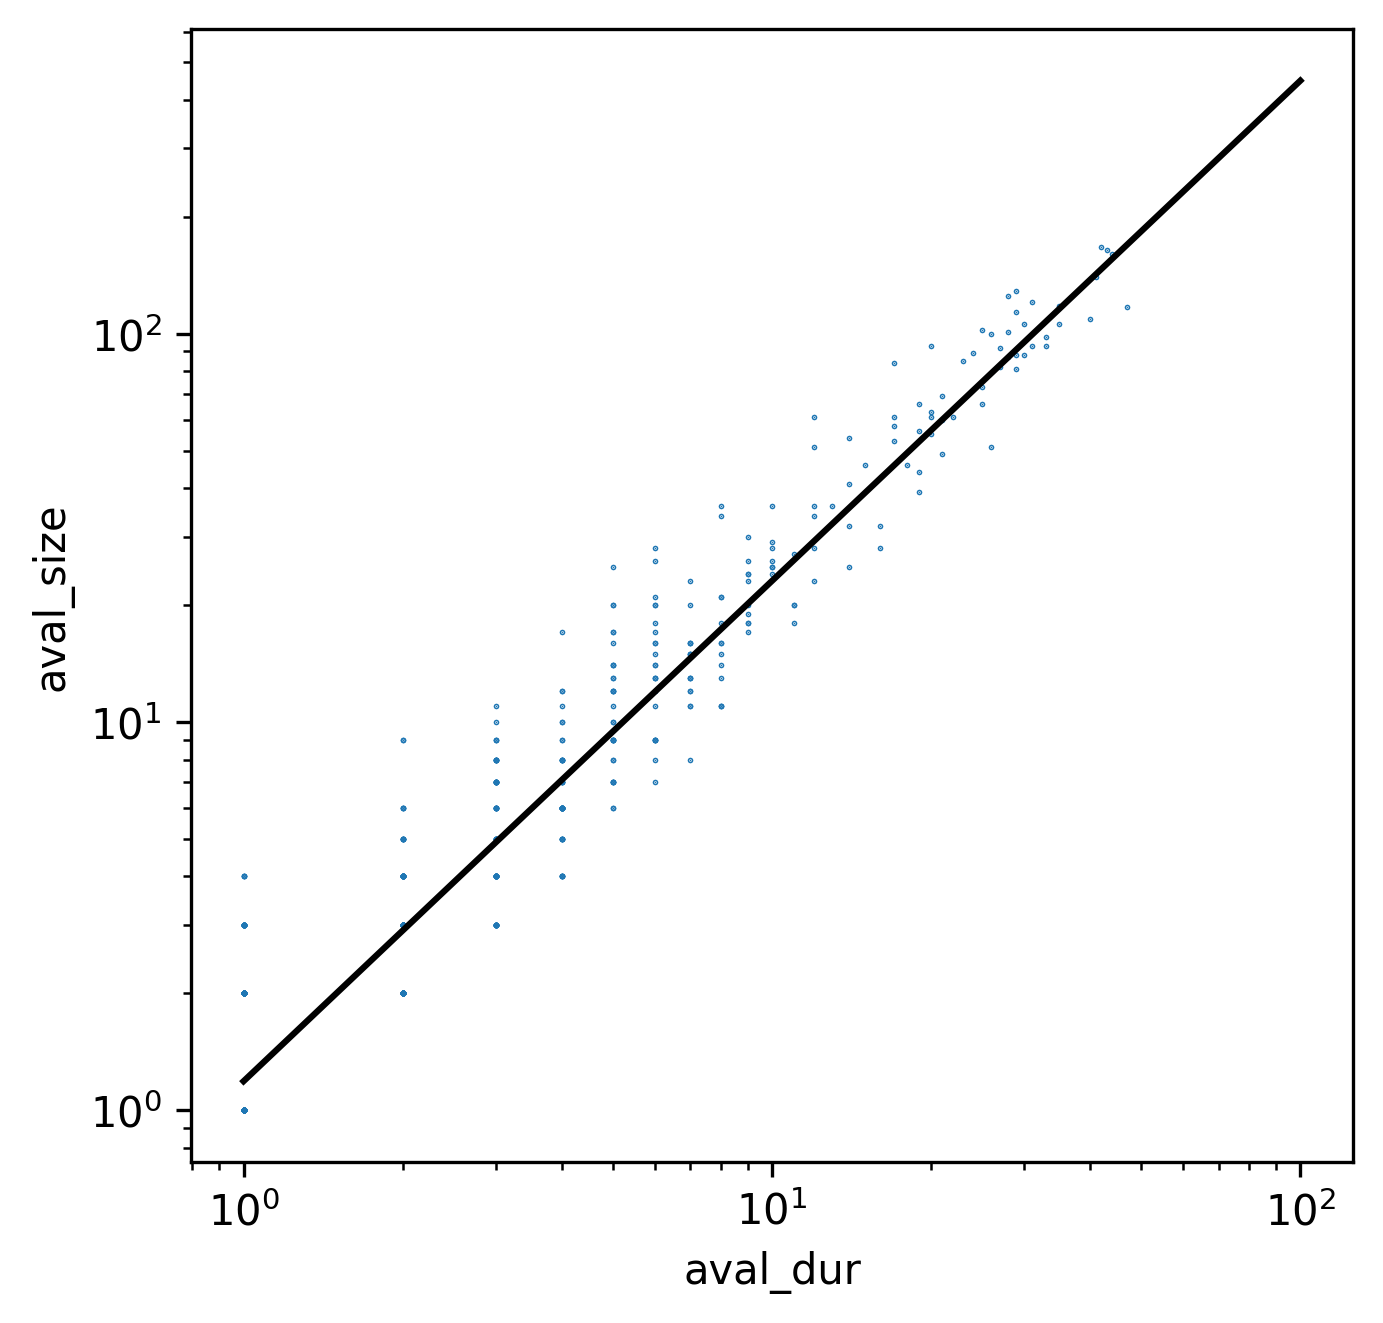

In [31]:
def total_avalanches(spike, threshold=1):
    aval_size_total = []
    aval_dur_total = []
    for i in range(40):
        seed = np.random.randint(low=0, high=1000, size=(100), dtype=np.int32)
        _, aval_size, aval_dur, _ = compute_avalanche(spike[:, seed], threshold)
        aval_size_total.append(aval_size)
        aval_dur_total.append(aval_dur)
    aval_size_total = np.concatenate(aval_size_total, axis=0)
    aval_dur_total = np.concatenate(aval_dur_total, axis=0)
    return aval_size_total, aval_dur_total
aval_size, aval_dur = total_avalanches(critical_spike, threshold=1)
k, _, _, _ = np.linalg.lstsq(np.stack([np.log10(aval_dur), np.ones(len(aval_size))], axis=1), np.log10(aval_size[:, np.newaxis]))
print(k)
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.gca()
ax.scatter(aval_dur[:1000], aval_size[:1000], marker=".", s=0.5)
ax.set_xlabel("aval_dur")
ax.set_ylabel("aval_size")
x = np.linspace(0,2, 50)
y = x * k[0] + k[1]
ax.plot(np.power(10, x), np.power(10, y), color="k")
ax.set_xscale("log")
ax.set_yscale("log")
fig.savefig("linear_dur_size.pdf")

# spike of multi size block from paramter of critical point

original data shape (100, 800, 1000)


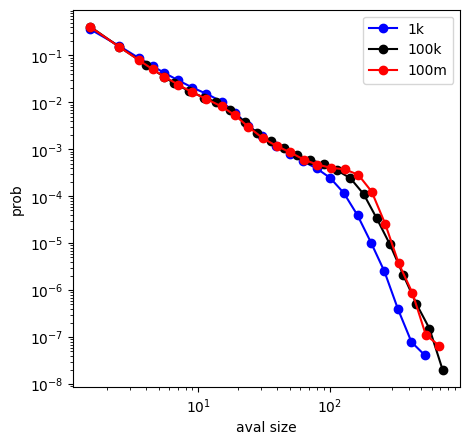

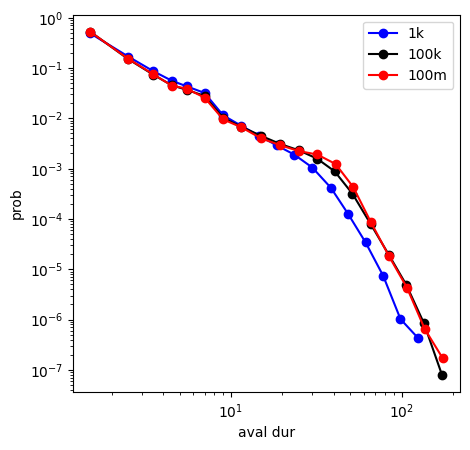

In [17]:
small_spike = np.load("../data/size_influence_from_critical/spike_0.npy")
medium_spike = np.load("../data/size_influence_from_critical/spike_25.npy")
big_spike = np.load("../data/size_influence_from_critical/spike_47.npy")
print("original data shape", small_spike.shape)

small_spike = small_spike.reshape((-1, small_spike.shape[-1]))[2000:, ]
medium_spike = medium_spike.reshape((-1, medium_spike.shape[-1]))[2000:, ]
big_spike = big_spike.reshape((-1, big_spike.shape[-1]))[2000:, ]

def total_avalanches(spike, threshold=1):
    aval_size_total = []
    aval_dur_total = []
    for i in range(40):
        seed = np.random.randint(low=0, high=1000, size=(100), dtype=np.int32)
        _, aval_size, aval_dur, _ = compute_avalanche(spike[:, seed], threshold)
        aval_size_total.append(aval_size)
        aval_dur_total.append(aval_dur)
    aval_size_total = np.concatenate(aval_size_total, axis=0)
    aval_dur_total = np.concatenate(aval_dur_total, axis=0)
    return aval_size_total, aval_dur_total

fig1 = plt.figure(figsize=(5, 5), dpi=100)
ax1 = fig1.gca()
fig2 = plt.figure(figsize=(5, 5), dpi=100)
ax2 = fig2.gca()
aval_size, aval_dur = total_avalanches(small_spike)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max(), discrete=True)
fit.plot_pdf(ax=ax1, original_data=True, c="b",linestyle='-', marker='o',label="1k")  #  marker='o',
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max(), discrete=True)
fit.plot_pdf(ax=ax2, original_data=True, c="b", marker='o', linestyle='-', label="1k")


aval_size, aval_dur = total_avalanches(medium_spike)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max(), discrete=True)
fit.plot_pdf(ax=ax1, original_data=True,  c="k", linestyle='-', marker='o', label="100k")
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max(), discrete=True)
fit.plot_pdf(ax=ax2, original_data=True, c="k", marker='o', linestyle='-', label="100k")

aval_size, aval_dur = total_avalanches(big_spike)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max(), discrete=True)
fit.plot_pdf(ax=ax1, original_data=True, c="r", linestyle='-', marker='o', label="100m")
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max(), discrete=True)
fit.plot_pdf(ax=ax2, original_data=True, c="r", marker='o', linestyle='-', label="100m")
ax1.set_xlabel("aval size")
ax1.set_ylabel("prob")
ax1.legend()
ax2.set_xlabel("aval dur")
ax2.set_ylabel("prob")
ax2.legend()
fig1.savefig("./multi_size_avalanches.png")
# fig2.savefig("./aval_dur.png")

Text(0.5, 0, 'time(ms)')

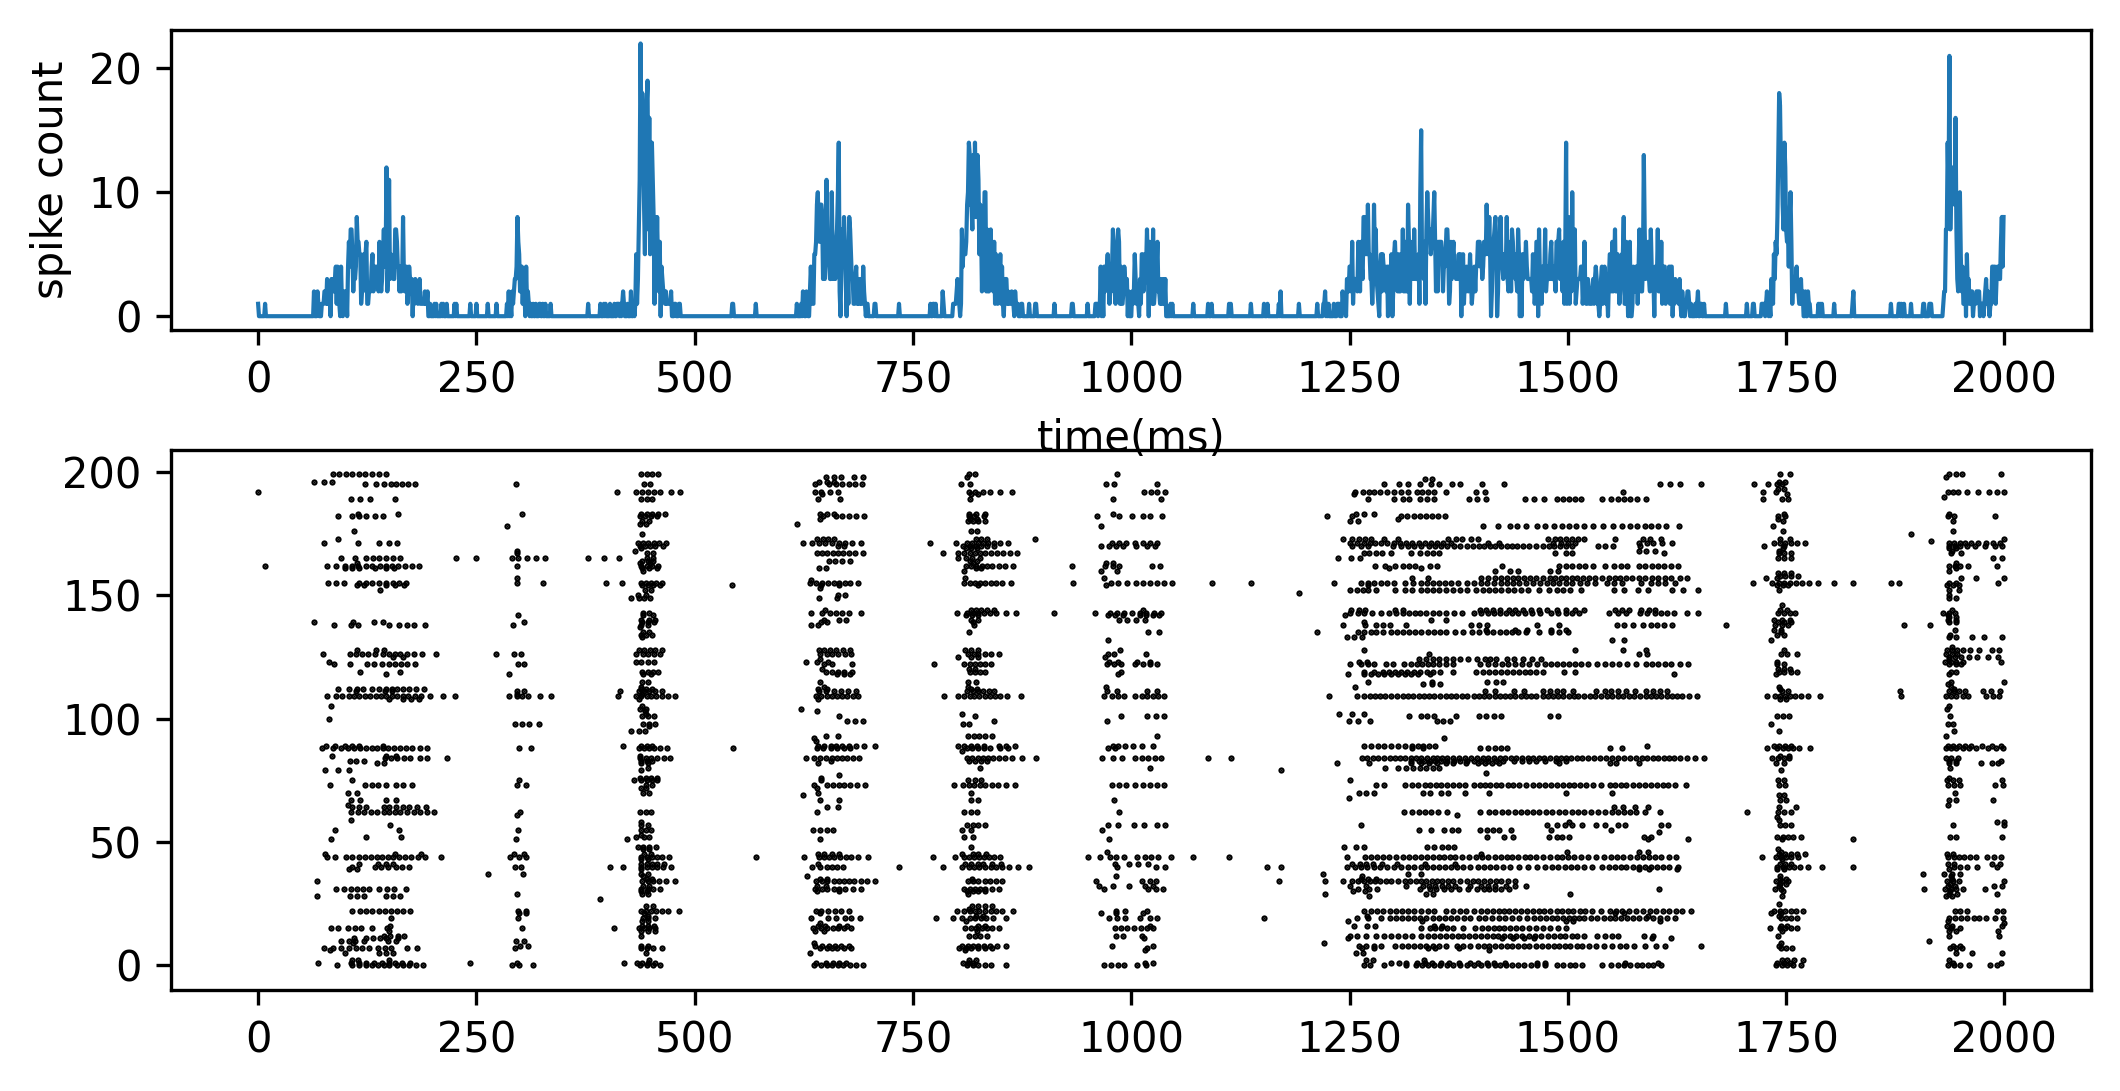

In [10]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*small_spike[-2000:, 500:700].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(small_spike[-2000:, 500:700], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

Text(0.5, 0, 'time(ms)')

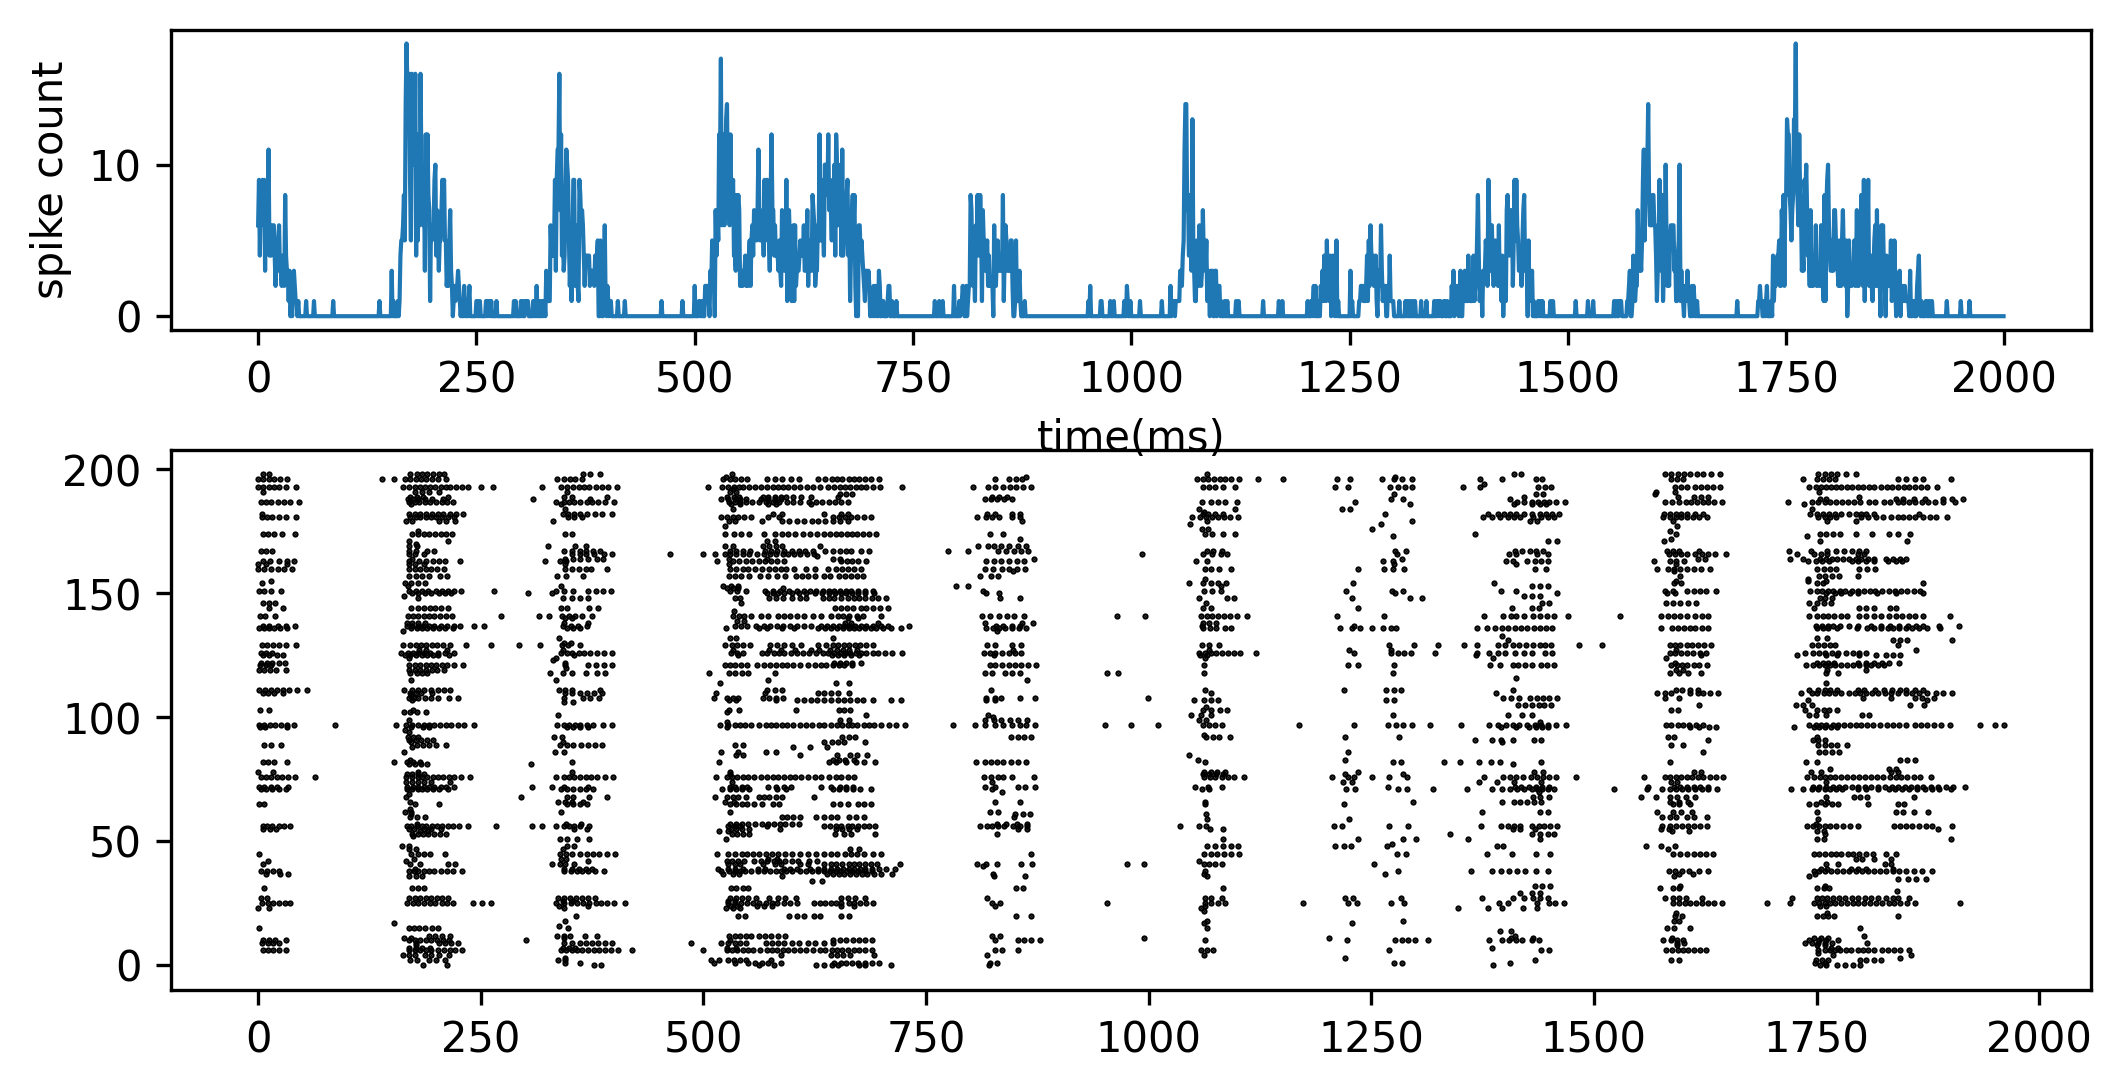

In [11]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*medium_spike[-2000:, 500:700].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(medium_spike[-2000:, 500:700], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

Text(0.5, 0, 'time(ms)')

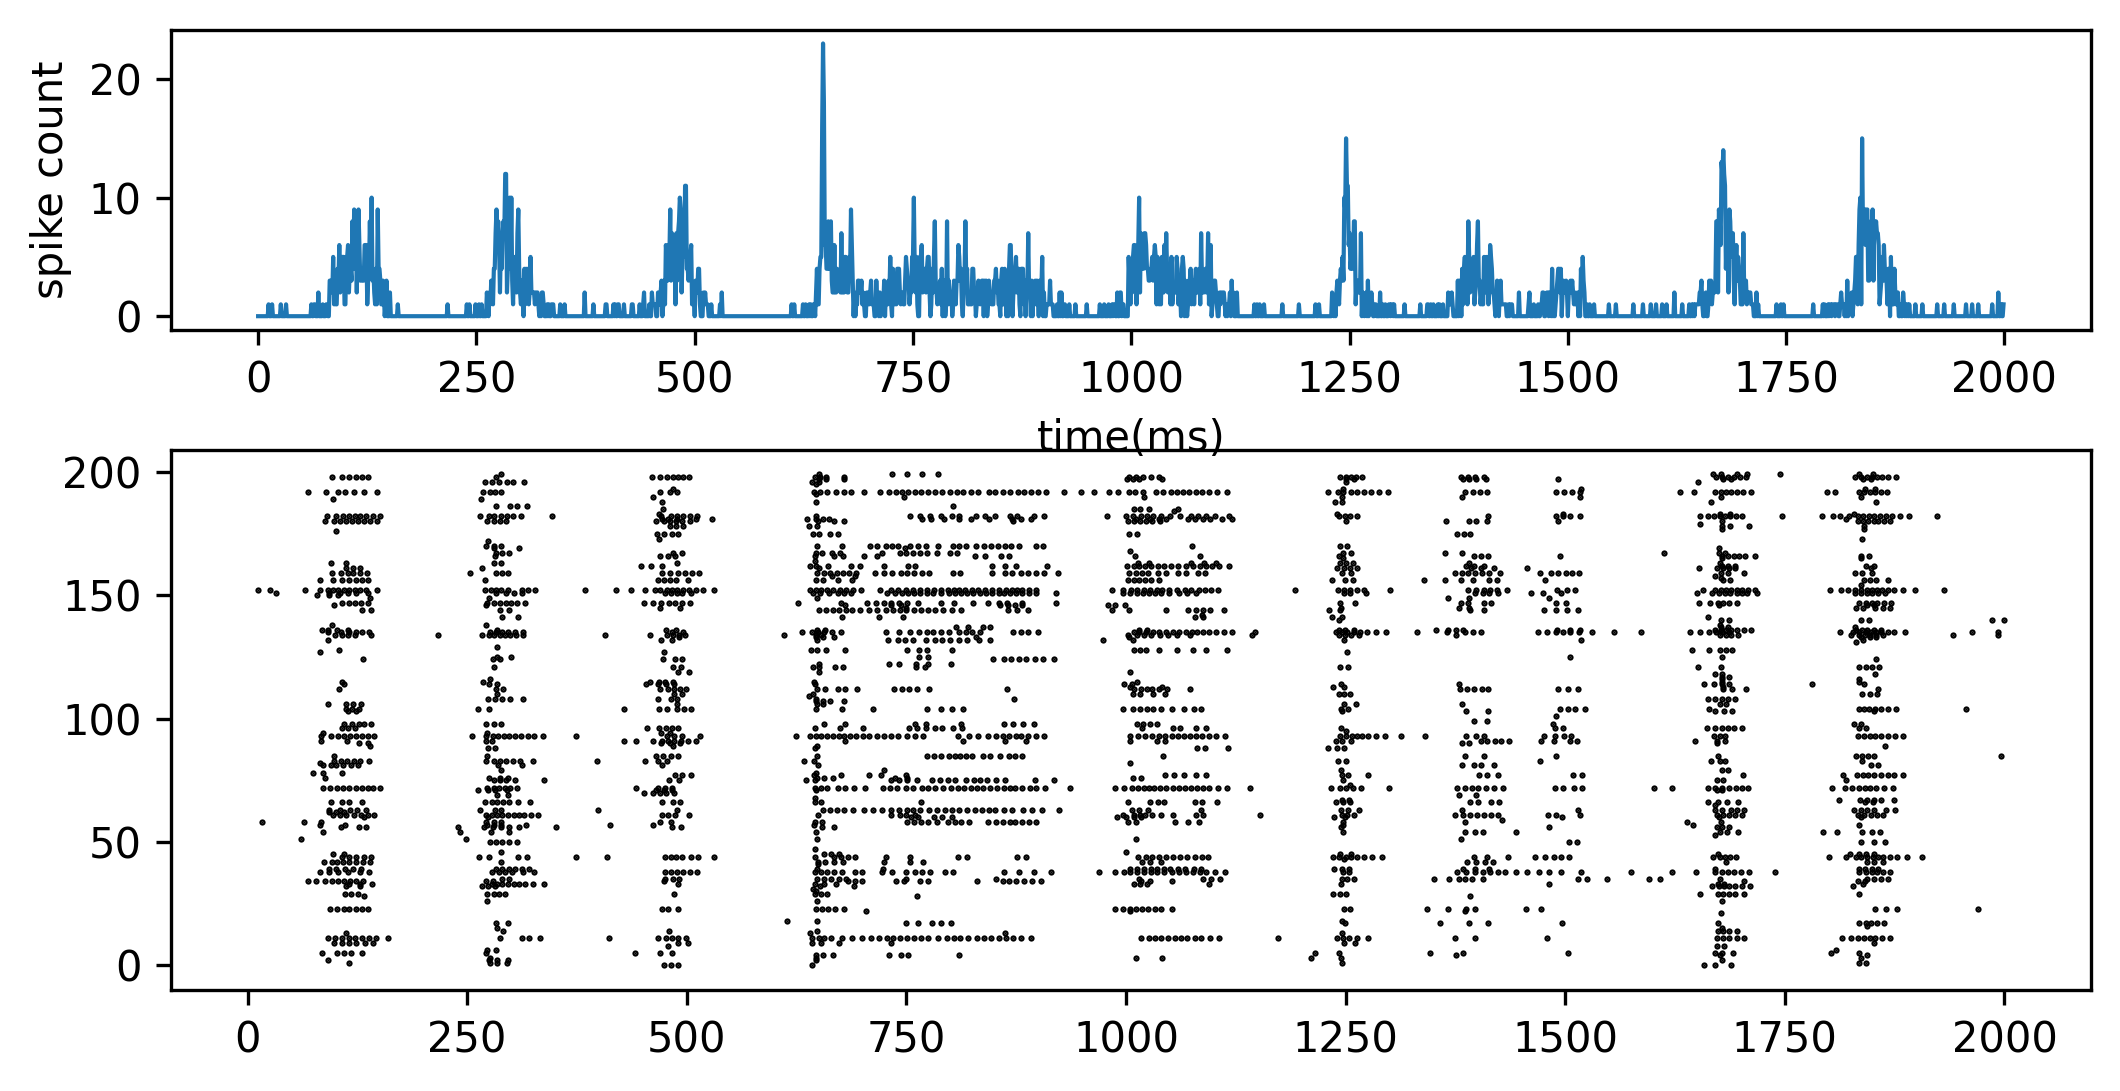

In [12]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*big_spike[-2000:, 500:700].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(big_spike[-2000:, 500:700], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")